In [1]:
import os
dataset_directory = '.\Data'
datasets = [(path, files) for path, _, files in os.walk(dataset_directory) if len(files) > 0]
datasets

[('.\\Data',
  ['20171220_213158911_iOS.jpg',
   '20171220_213245412_iOS.jpg',
   '20171220_213256286_iOS.jpg',
   '20171220_213305258_iOS.jpg',
   '20171220_213315432_iOS.jpg',
   '20171220_213325306_iOS.jpg',
   '20171220_213336280_iOS.jpg',
   '20171220_213349323_iOS.jpg'])]

In [2]:
import matplotlib.image as mpimg
from skimage.transform import resize, rescale

imgs = [mpimg.imread(dn+'\\'+fn) for (dn,fns) in datasets for fn in fns]
print('Resizing...', [img.shape for img in imgs])
augment_imgs = False
if augment_imgs:
    imgs = [crop(img, ((5,0),(3,2),(0,0))) for img in imgs]
imgs_128 = [resize(img, (128,128), anti_aliasing=True) for img in imgs]
print('Done resizing.', [img.shape for img in imgs_128])

Resizing... [(2018, 2010, 3), (2188, 1903, 3), (1903, 1844, 3), (2154, 2031, 3), (2131, 2039, 3), (1941, 2172, 3), (2146, 2244, 3), (2304, 2411, 3)]
Done resizing. [(128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3)]


In [3]:
import math
def shift_hsv(hsv, shift_h, shift_v=0.0):
    h_new = hsv[0] + shift_h
    if (h_new > 1.0):
        h_new = h_new - 1.0
    v_new = hsv[2] + shift_v
    v_new = min(v_new, 1.0)
    v_new = max(v_new, 0.0)
    return [h_new,hsv[1],v_new]
print(shift_hsv([0.9,0.3,0.5], 0.39, shift_v=0.1))

[0.29000000000000004, 0.3, 0.6]


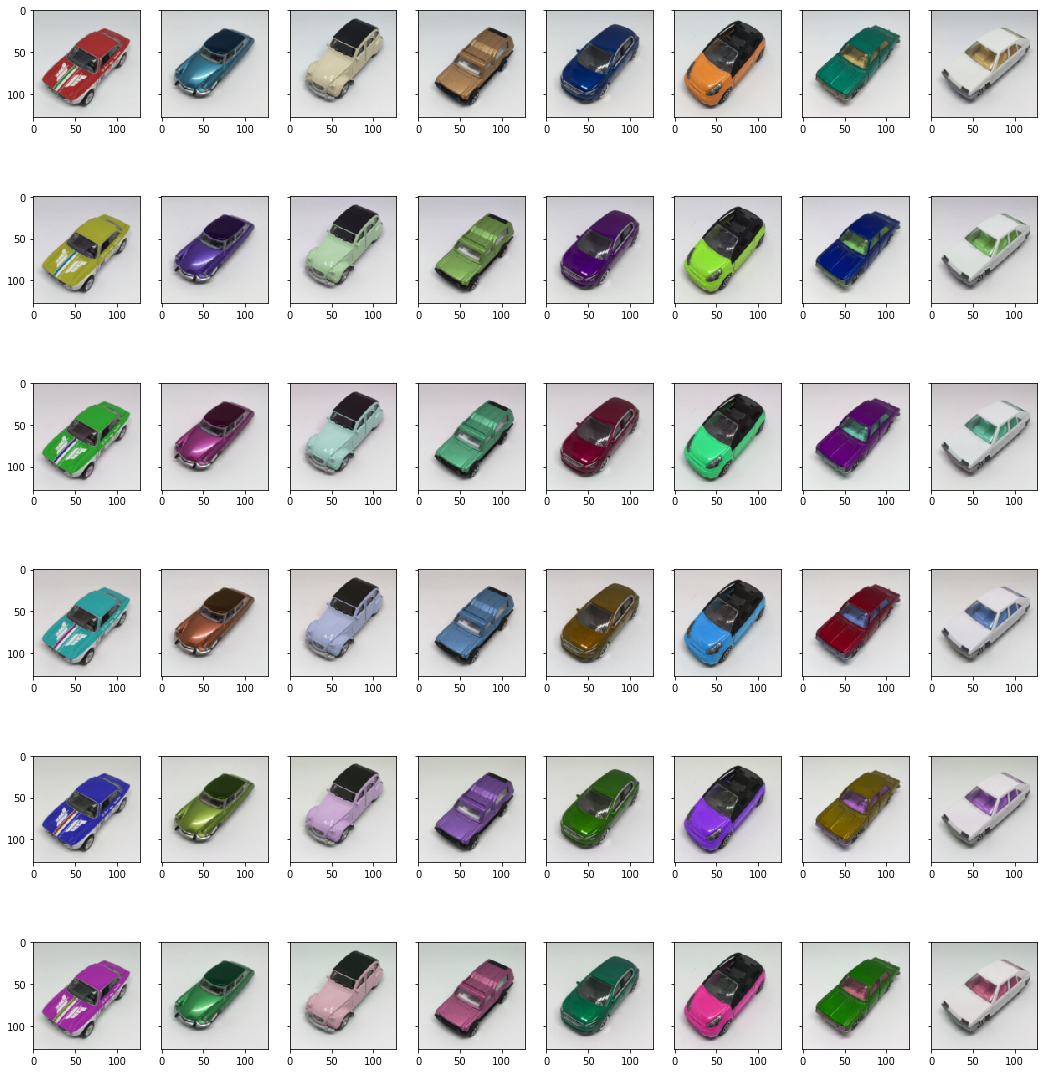

In [4]:
%matplotlib inline
from matplotlib import colors
import matplotlib.pyplot as plt
from skimage.util import crop, pad
import numpy as np

x_train = []
fig, axes = plt.subplots(6,len(imgs_128),sharey=True, figsize=(18,20))
for shift_h in range(6):
    for n in range(len(imgs_128)):
        img_hsv = colors.rgb_to_hsv(imgs_128[n])
        img_hsv = np.apply_along_axis(shift_hsv, 2, img_hsv, shift_h=shift_h/6.0, shift_v=0.0)
        x_train.append(img_hsv)
        # print(img_hsv.shape)
        axes[shift_h][n].imshow(colors.hsv_to_rgb(img_hsv))

In [5]:
from keras.layers import Dense, Input, SpatialDropout2D
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import LocallyConnected2D, ZeroPadding2D
from keras.layers import MaxPooling2D, UpSampling2D
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import ActivityRegularization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K


Using TensorFlow backend.


In [6]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [7]:
def build_autoencoder(sz, optimizer, loss):

    # create encoder side
    input_img = Input(shape=(sz,sz,3))
    x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = SpatialDropout2D(0.1)(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = LocallyConnected2D(32, (3,3))(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    encoded_layer = ActivityRegularization(l1=0.0e-4,l2=0.0e-4)(x)

    # shape info needed to build decoder model
    shape = K.int_shape(encoded_layer)

    # generate latent vector Q(z|X)
    latent_dim = 2
    x = Flatten()(encoded_layer)
    x = Dense(32, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


    encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    # plot_model(encoder, to_file='data\dicom_encoder.png', show_shapes=True)

    # TODO: add threshold layer for sparsity test



    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    x = LocallyConnected2D(32, (3,3))(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    decoded_layer = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)
    decoder = Model(latent_inputs, decoded_layer)
    decoder.summary()
    # plot_model(decoder, to_file='data\dicom_decoder.png', show_shapes=True)

    autoencoder_output = decoder(encoder(input_img)[2])
    autoencoder = Model(input_img, autoencoder_output, name='ae')
    autoencoder.compile(optimizer=optimizer, loss=loss)
    autoencoder.summary()
    # plot_model(autoencoder, to_file='data\dicom_autoencoder.png', show_shapes=True)

    return autoencoder, encoder, decoder

In [30]:
vae, enc, dec = build_autoencoder(128, 'adadelta', 'categorical_crossentropy') # 'mean_squared_error')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 128, 128, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
spatial_dropout2d_2 (SpatialDro (None, 64, 64, 32)   0           max_pooling2d_5[0][0]            
____________________________________________________________________________________________

In [31]:
x_train = np.array(x_train)
x_train # len(x_train), [data.shape for data in x_train]

array([[[[0.53333333, 0.02487562, 0.78823529],
         [0.54166667, 0.02      , 0.78431373],
         [0.53333333, 0.02487562, 0.78823529],
         ...,
         [0.54166667, 0.02020202, 0.77647059],
         [0.61111111, 0.01515152, 0.77647059],
         [0.53333333, 0.02525253, 0.77647059]],

        [[0.53333333, 0.02487562, 0.78823529],
         [0.53333333, 0.02487562, 0.78823529],
         [0.53333333, 0.02487562, 0.78823529],
         ...,
         [0.54166667, 0.02020202, 0.77647059],
         [0.54166667, 0.02020202, 0.77647059],
         [0.58333333, 0.02020202, 0.77647059]],

        [[0.54166667, 0.0199005 , 0.78823529],
         [0.54166667, 0.0199005 , 0.78823529],
         [0.53333333, 0.02475248, 0.79215686],
         ...,
         [0.54166667, 0.02020202, 0.77647059],
         [0.54166667, 0.02020202, 0.77647059],
         [0.54166667, 0.02020202, 0.77647059]],

        ...,

        [[0.        , 0.        , 0.88235294],
         [0.        , 0.        , 0.88235294]

In [32]:
x_train.shape

(48, 128, 128, 3)

In [ ]:
import random
x_test = np.array(random.sample(list(x_train), int(len(x_train)/10)))
vae.fit(x_train, x_train, epochs=75, batch_size=256, 
        shuffle=True, validation_data=(x_test,x_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 48 samples, validate on 4 samples
Epoch 1/75
48/48 [==============================] - 13s 262ms/step - loss: 1.4844 - val_loss: 1.5891
Epoch 2/75
48/48 [==============================] - 5s 113ms/step - loss: 1.4823 - val_loss: 1.5867
Epoch 3/75
48/48 [==============================] - 6s 116ms/step - loss: 1.4799 - val_loss: 1.5840
Epoch 4/75
48/48 [==============================] - 5s 114ms/step - loss: 1.4770 - val_loss: 1.5802
Epoch 5/75
48/48 [==============================] - 5s 113ms/step - loss: 1.4733 - val_loss: 1.5757
Epoch 6/75
48/48 [==============================] - 5s 112ms/step - loss: 1.4686 - val_loss: 1.5694
Epoch 7/75
48/48 [==============================] - 6s 116ms/step - loss: 1.4622 - val_loss: 1.5607
Epoch 8/75
48/48 [==============================] - 6s 119ms/step - loss: 1.4534 - val_loss: 1.5483
Epoch 9/75
48/48 [==============================] - 5s 113ms/s

In [27]:
print(x_test.shape)
encode_only_imgs = enc.predict(x_test)[2]   # z parameter is #2
print(encode_only_imgs.shape)

(4, 128, 128, 3)
(4, 2)


In [28]:
for n in range(len(encode_only_imgs)):
    print("shape of encoded = ", encode_only_imgs.shape)
    print("encoded = ", encode_only_imgs)
    hist, bins = np.histogram(encode_only_imgs)
    print(hist)
    print(bins)

# add random values to decoded
# perturb_vectors = np.random.standard_normal(size=encode_only_imgs[2].shape)
# perturb_vectors = np.multiply(perturb_vectors, 10.6)
encode_only_imgs_z = encode_only_imgs # np.add(encode_only_imgs[2], perturb_vectors)

decoded_imgs = dec.predict(encode_only_imgs_z)

shape of encoded =  (4, 2)
[2 1 2 0 1 0 0 0 1 1]
[0.07610934 0.1971702  0.31823105 0.4392919  0.56035274 0.6814136
 0.8024745  0.92353535 1.0445962  1.165657   1.2867179 ]
shape of encoded =  (4, 2)
[2 1 2 0 1 0 0 0 1 1]
[0.07610934 0.1971702  0.31823105 0.4392919  0.56035274 0.6814136
 0.8024745  0.92353535 1.0445962  1.165657   1.2867179 ]
shape of encoded =  (4, 2)
[2 1 2 0 1 0 0 0 1 1]
[0.07610934 0.1971702  0.31823105 0.4392919  0.56035274 0.6814136
 0.8024745  0.92353535 1.0445962  1.165657   1.2867179 ]
shape of encoded =  (4, 2)
[2 1 2 0 1 0 0 0 1 1]
[0.07610934 0.1971702  0.31823105 0.4392919  0.56035274 0.6814136
 0.8024745  0.92353535 1.0445962  1.165657   1.2867179 ]


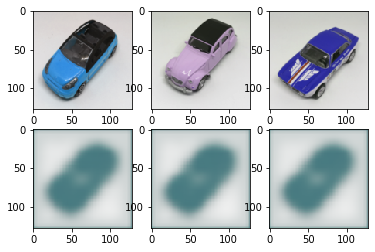

In [29]:
def show_original_decoded(original, decoded, sz):
    n = 3  # how many digits we will display
    plt.figure(figsize=(n*2, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(colors.hsv_to_rgb(original[i].reshape(128, 128, 3)))       
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(colors.hsv_to_rgb(decoded[i].reshape(128, 128, 3)))
    plt.show() # block=True)
show_original_decoded(x_test, decoded_imgs, 128)